In [22]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
from stable_baselines3 import PPO, A2C, SAC, DQN, TD3, DDPG
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)



In [ ]:


class JobSchedulingEnv(gym.Env):
    def __init__(self, num_jobs=5):
        super(JobSchedulingEnv, self).__init__()
        self.num_jobs = num_jobs

        self.action_space = spaces.Box(low=0, high=1, shape=(num_jobs + 1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(num_jobs, 6), dtype=np.float32)

        self.jobs = []
        self.time = 0
        self.done_jobs = []

    def reset(self, seed=None, options=None, jobs=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self.time = 0
        self.done_jobs = []

        if jobs is not None:
            self.jobs = [tuple(job) for job in jobs]
            self.num_jobs = len(self.jobs)
        else:
            # Generate random jobs
            arrival_times = np.sort(np.random.normal(loc=5, scale=2, size=self.num_jobs))
            arrival_times = np.clip(arrival_times, 0, 10) / 10
            execution_times = np.clip(np.random.normal(loc=5, scale=2, size=self.num_jobs), 1, 10) / 10
            priorities = np.random.choice([1, 2, 3, 4, 5], self.num_jobs, p=[0.1, 0.2, 0.4, 0.2, 0.1]) / 5
            deadlines = (arrival_times + execution_times + np.random.randint(3, 10, size=self.num_jobs)) / 20
            cpu_requirements = np.random.randint(1, 11, size=self.num_jobs) / 10
            job_types = np.random.choice([0, 1], self.num_jobs)

            self.jobs = list(zip(arrival_times, execution_times, priorities, deadlines, cpu_requirements, job_types))

        self.jobs.sort(key=lambda x: x[0])
        return self._get_observation(), {}

    def _get_observation(self):
        obs = np.zeros((self.num_jobs, 6), dtype=np.float32)
        for i, job in enumerate(self.jobs):
            obs[i] = job
        return obs

    def step(self, action):
        scheduling_scores = action[:len(self.jobs)]
        resource_allocation = action[-1]

        job_index = int(np.argmax(scheduling_scores))
        if job_index >= len(self.jobs):
            return self._get_observation(), -10, True, False, {}

        selected_job = self.jobs.pop(job_index)
        arrival_time, execution_time, priority, deadline, cpu_req, job_type = selected_job

        start_time = max(self.time, arrival_time)
        end_time = start_time + execution_time
        self.time = end_time

        waiting_time = start_time - arrival_time
        base_reward = -waiting_time - (execution_time / (priority + 1e-8)) - len(self.jobs) * 0.1

        if self.time > deadline:
            base_reward -= 10
        else:
            base_reward += 5

        optimal_resource = 0.7
        energy_penalty = 5 * abs(resource_allocation - optimal_resource)
        throughput_reward = 10 / (self.time + 1)

        reward = base_reward + throughput_reward - energy_penalty

        self.done_jobs.append((selected_job, start_time, end_time))

        done = len(self.jobs) == 0
        info = {
            "start_time": start_time,
            "end_time": end_time,
        }

        return self._get_observation(), reward, done, False, info


In [24]:
def fifo_scheduling(jobs):
    time = 0
    total_waiting_time = 0
    for job in sorted(jobs, key=lambda x: x[0]):  # sort by arrival_time
        arrival_time, execution_time, priority, deadline = job[:4]
        time = max(time, arrival_time) + execution_time
        total_waiting_time += time - arrival_time - execution_time
    return total_waiting_time


def sjf_scheduling(jobs):
    time = 0
    total_waiting_time = 0
    for job in sorted(jobs, key=lambda x: x[1]):  # sort by execution_time
        arrival_time, execution_time, priority, deadline = job[:4]
        time = max(time, arrival_time) + execution_time
        total_waiting_time += time - arrival_time - execution_time
    return total_waiting_time


def edf_scheduling(jobs):
    time = 0
    total_waiting_time = 0
    for job in sorted(jobs, key=lambda x: x[3]):  # sort by deadline
        arrival_time, execution_time, priority, deadline = job[:4]
        time = max(time, arrival_time) + execution_time
        if time > deadline:
            total_waiting_time += (
                time - deadline
            ) * 2  # heavier penalty for missing deadline
        else:
            total_waiting_time += time - arrival_time - execution_time
    return total_waiting_time


# def rr_scheduling(jobs, quantum=1):
#     time = 0
#     total_waiting_time = 0
#     queue = jobs.copy()

#     while queue:
#         job = queue.pop(0)
#         arrival_time, execution_time, priority, deadline = job[:4]

#         if time < arrival_time:
#             time = arrival_time

#         if execution_time > quantum:
#             time += quantum
#             queue.append((arrival_time, execution_time - quantum, priority, deadline))
#         else:
#             time += execution_time
#             total_waiting_time += time - arrival_time - execution_time

#     return total_waiting_time


Output()

Training PPO...


Output()

Total Reward for PPO: -549.7752264117025
Evaluation Reward for PPO: -51.14161458015442
Training A2C...


Output()

Total Reward for A2C: -494.67066198164423
Evaluation Reward for A2C: -46.14815645217895
Training SAC...


Output()

Total Reward for SAC: -428.7120233531356
Evaluation Reward for SAC: -42.855403423309326
Training TD3...


Output()

Total Reward for DDPG: -418.46438271957777
Evaluation Reward for DDPG: -45.1791485786438


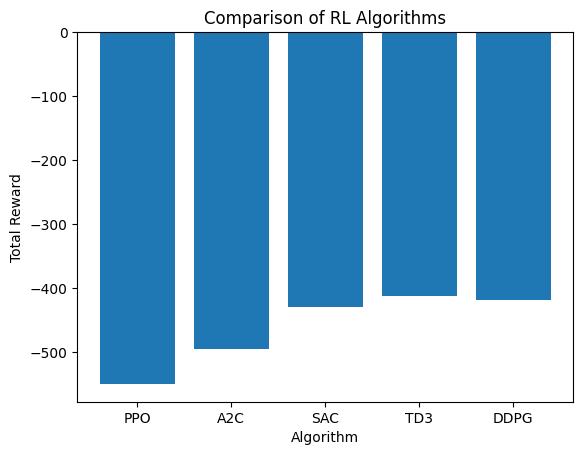

In [25]:
algos = {"PPO": PPO, "A2C": A2C, "SAC": SAC, "TD3": TD3,  "DDPG": DDPG}
results = {}


env = JobSchedulingEnv(num_jobs=5)


# Train and evaluate each algorithm


for name, algo in algos.items():
    print(f"Training {name}...")
    model = algo("MlpPolicy", env, verbose=0, tensorboard_log="./tb_logs/")
    model.set_random_seed(42)
    model.learn(total_timesteps=5000, progress_bar=True)

    total_reward = 0
    for _ in range(10):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

    results[name] = total_reward
    
    eval_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Total Reward for {name}: {total_reward}")
    print(f"Evaluation Reward for {name}: {eval_reward}")
    

plt.bar(results.keys(), results.values())
plt.xlabel("Algorithm")
plt.ylabel("Total Reward")
plt.title("Comparison of RL Algorithms")
plt.show()


In [ ]:
ALGO = "SAC"
POLICY = "MlpPolicy"


env = JobSchedulingEnv(num_jobs=5)

model = algos[ALGO](POLICY, env, verbose=0, tensorboard_log="./tb_logs/")

model.set_random_seed(86)
model.learn(total_timesteps=20000, progress_bar=True)

# obs, _ = env.reset()
# done = False
rewards = []

for _ in range(10):  # Test for 10 episodes
    obs, _ = env.reset()
    done = False
    episode_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
    rewards.append(episode_reward)
    
eval_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

print("Average Reward:", np.mean(rewards))
print(f"Evaluation Reward for {ALGO}: {eval_reward}")


Output()

Average Reward: -38.911716644084116


AttributeError: 'JobSchedulingEnv' object has no attribute 'total_waiting_time'

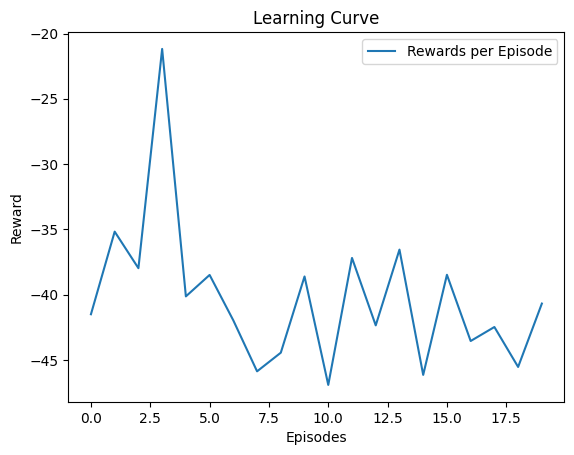

In [30]:
rewards_per_episode = []
obs, _ = env.reset()
ep_reward = 0

for i in range(100):  # total steps
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    ep_reward += reward

    if done:
        rewards_per_episode.append(ep_reward)
        obs, _ = env.reset()
        ep_reward = 0  # reset reward counter for next episode
        
plt.plot(rewards_per_episode, label="Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Learning Curve")
plt.legend()
plt.show()


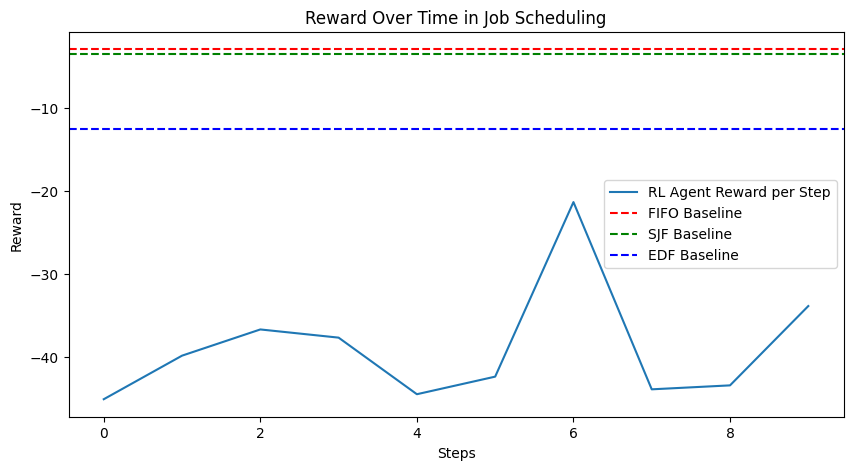

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="RL Agent Reward per Step")
fifo = -fifo_scheduling(env.jobs)
sjf = -sjf_scheduling(env.jobs)
edf = -edf_scheduling(env.jobs)
plt.axhline(y=fifo, color="r", linestyle="--", label="FIFO Baseline")
plt.axhline(y=sjf, color="g", linestyle="--", label="SJF Baseline")
plt.axhline(y=edf, color="b", linestyle="--", label="EDF Baseline")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Reward Over Time in Job Scheduling")
plt.legend()
plt.show()


In [32]:
model.save(f"js_model_{ALGO}.zip")


In [34]:
loaded_model = algos[ALGO].load(f"js_model_{ALGO}.zip", env=env)
obs, _ = env.reset()
done = False
rewards = []
while not done:
    action, _ = loaded_model.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    rewards.append(reward)
print("Loaded Model Average Reward:", np.mean(rewards))
print("Loaded Model Done Jobs:", len(env.done_jobs))

Loaded Model Average Reward: -8.979825551677251
Loaded Model Done Jobs: 5
